### Initialize library

In [1]:
import sys
import os

# Add the directory containing 'vlm_library.py' and 'sam2' to the Python path
sys.path.append('osg/segment_anything_2/')

In [2]:
from limp.utils.gen_utils import ltl2dfa, llm4tl, referent_verification, task_structure_verification, get_spatial_referents
from osg.utils.general_utils import load_data, create_observation_graph
from osg.vlm_library import vlm_library
from limp.planner.multi_level_planner import progressive_motion_planner

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-08-05 17:05:30.180527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 17:05:30.198821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 17:05:30.204426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 17:05:30.216925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 17:05:31.611318: W tensorflow/compiler/tf2

In [3]:
tmp_fldr=f"results/"
vlm_instance = vlm_library(vl_model="owl_vit",  seg_model="sam2", tmp_fldr=tmp_fldr)


Visual language model: owl_vit
-------------------------------------------------
Segmentation model: SAM2
-------------------------------------------------


### Load data

In [4]:
data_path = "sample_data"

observation_data, edge_connectivity, env_pointcloud = load_data(data_path, tmp_fldr)
observations_graph, _, _, _ = create_observation_graph(observation_data,edge_connectivity,tmp_fldr=tmp_fldr)

0 out of 12 || Getting cardinal images for waypoint:balky-cuckoo-DSOhlw+wDw5TKMQhzKNg1Q==
1 out of 12 || Getting cardinal images for waypoint:bended-drum-ZK.nOK2ROH99jbDMGbrG3Q==
2 out of 12 || Getting cardinal images for waypoint:brainy-eel-acD1gEPuOhQgqad45uHuXw==
3 out of 12 || Getting cardinal images for waypoint:frayed-emu-M5JSw0IiYB8xYBwfswR41Q==
4 out of 12 || Getting cardinal images for waypoint:garish-rat-RgSDxBIafXZwgLb2o+h3TA==
5 out of 12 || Getting cardinal images for waypoint:leafy-mayfly-8hSmtSRh9YMd0eyKxJ6Tjw==
6 out of 12 || Getting cardinal images for waypoint:lemony-gibbon-44n7dioWNlkPvLqiIcb2gg==
7 out of 12 || Getting cardinal images for waypoint:lethal-fish-xlr1rhR2yqmfn88mEo7FTw==
8 out of 12 || Getting cardinal images for waypoint:phoney-shark-vJbZmiet4YMbuu.hDi4IOA==
9 out of 12 || Getting cardinal images for waypoint:scared-redbug-AHDnuMg2GzoyJUZUrvMuYA==
10 out of 12 || Getting cardinal images for waypoint:tan-mamba-2DaJ2+ZpP88jbK93.0w4nA==
11 out of 12 || Ge

### Language to  Ltl

In [5]:
#Demo instruction: Bring the green plush toy to the whiteboard in front of it

print(f"\n*************************************************************************\nInstruction Following\n*************************************************************************")
input_lang_instruction = input("Enter the natural language description of the task: ")

in_context_examples = "limp/language/temporal_logic/ltl_datasets/efficient-eng-2-ltl-droneplanning"
in_context_count    = 10
lang2ltl_path       = "limp/language/temporal_logic/embedding_cache/small-droneplanning_lang2ltl.pkl" 
lang2embedding_path = "limp/language/temporal_logic/embedding_cache/small-droneplanning_lang2embeddings.pkl"

print(f'\nInput instruction: "{input_lang_instruction}"')
print("Running Language Instruction Module ...")

strategy_choice="two_stage_similar_embedding"
# strategy_choice="two_stage_random_embedding"
# strategy_choice="single_stage"

encoding_map, response_ltl, spot_ltl, llm_response_history= llm4tl(input_lang_instruction, in_context_examples, lang2embedding_path, lang2ltl_path, in_context_count, enable_prints=False, strategy=strategy_choice)
original_encoding_map, original_response_ltl, original_spot_ltl, original_llm_response_history = encoding_map, response_ltl, spot_ltl, llm_response_history 

print("Spotify predicate encoding map: ", encoding_map)
print("Response LTL formula: ", response_ltl)
print("Cleaned LTL formula: ", spot_ltl,"\n")

display(spot_ltl)


*************************************************************************
Instruction Following
*************************************************************************

Input instruction: "bring the green plush toy to the whiteboard in front of it"
Running Language Instruction Module ...
		Model: gpt-4 || Deterministic?: False
		Model: gpt-4 || Deterministic?: False
Spotify predicate encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
Response LTL formula:  F ( A & F ( B & F ( C & F ( D ) ) ) )
Cleaned LTL formula:  F(A & F(B & F(C & FD))) 



spot.formula("F(A & F(B & F(C & FD)))")

### Interactive Symbol Verification

In [6]:
# Referent verification
encoding_map, response_ltl, spot_ltl, llm_response_history  = referent_verification(input_lang_instruction, encoding_map, response_ltl, spot_ltl, llm_response_history, strategy_choice)

Original instruction:  bring the green plush toy to the whiteboard in front of it
Last llm ltl response:  F ( near[green_plush_toy] & F ( pick[green_plush_toy] & F ( near[whiteboard::isinfrontof(green_plush_toy)] & F ( release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)] ) ) ) ) 

*****************************
Referent Verification
*****************************
I extracted this list of relevant objects based on your instruction:
	* green_plush_toy
	* whiteboard::isinfrontof(green_plush_toy)
Does this match your intention? (y/n)


In [7]:
#Task structure verification
encoding_map, response_ltl, spot_ltl, llm_response_history, selected_dfa_path  = task_structure_verification(input_lang_instruction, encoding_map, response_ltl, spot_ltl, llm_response_history, strategy_choice)

Plausible DFA paths to goal:  [[0, 1, 2, 3, 4]] Selected_path:  [0, 1, 2, 3, 4] 

Original instruction:  bring the green plush toy to the whiteboard in front of it
Last llm ltl response:  F ( near[green_plush_toy] & F ( pick[green_plush_toy] & F ( near[whiteboard::isinfrontof(green_plush_toy)] & F ( release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)] ) ) ) )
Encoded form:  F(A & F(B & F(C & FD))) 

*****************************
Task Structure Verification
*****************************
Based on my understanding here is the sequence of subgoal objectives needed to satisfy the task:
Subgoal_1:
	 Logical Expression: A&!B
	 Decoded Expression: near[green_plush_toy] & ! pick[green_plush_toy]
	 English translation: I should be near the [green_plush_toy] and not have picked up the [green_plush_toy]
Subgoal_2:
	 Logical Expression: B&!C
	 Decoded Expression: pick[green_plush_toy] & ! near[whiteboard::isinfrontof(green_plush_toy)]
	 English translation: I should have picked up the 

In [8]:
# Visualize original and verified results
print("*****************************************\nOriginal Results\n*****************************************")
print("Original encoded formula: ",original_spot_ltl)
print("Original encoding map: ",original_encoding_map)
print("*****************************************\nAfter Verification\n*****************************************")
print("Verified encoded formula: ",spot_ltl)
print("Verified encoding map: ",encoding_map)

*****************************************
Original Results
*****************************************
Original encoded formula:  F(A & F(B & F(C & FD)))
Original encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
*****************************************
After Verification
*****************************************
Verified encoded formula:  F(A & F(B & F(C & FD)))
Verified encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}


### Construct task dfa from ltl

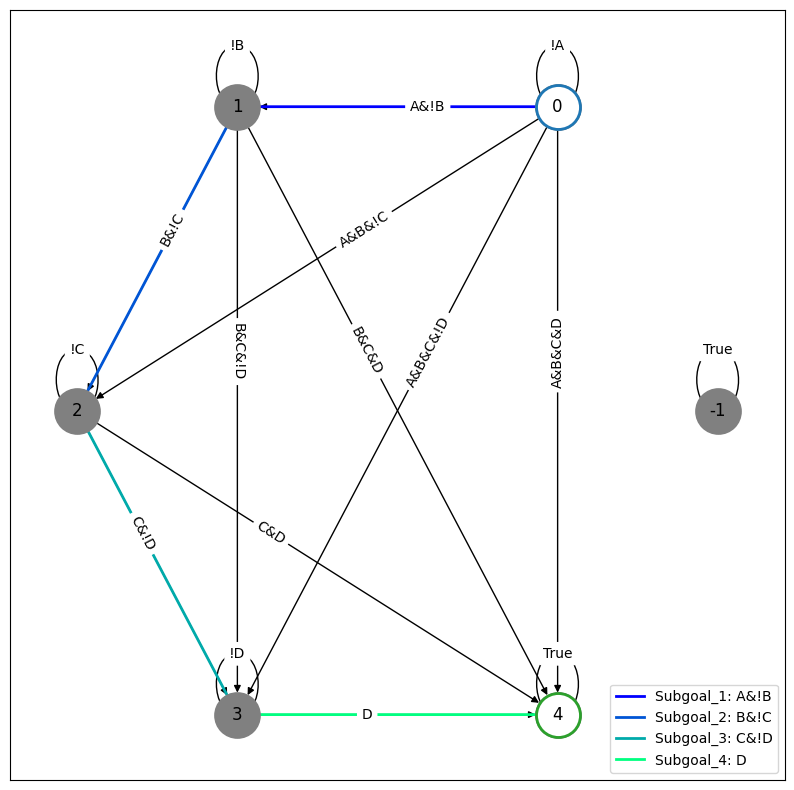

********************************
Task: F(A & F(B & F(C & FD)))
Symbolic maping: {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
********************************
Task Dfa Details
********************************
Initial_state    : 0
Accepting_states :[4]
Ltl2state        :{'False': -1, ('until', 'True', ('and', 'A', ('until', 'True', ('and', 'B', ('until', 'True', ('and', 'C', ('until', 'True', 'D'))))))): 0, ('until', 'True', ('and', 'B', ('until', 'True', ('and', 'C', ('until', 'True', 'D'))))): 1, ('until', 'True', ('and', 'C', ('until', 'True', 'D'))): 2, ('until', 'True', 'D'): 3, 'True': 4}
DFA Transitions:
	 Edge: (0, 0, '!A')
	 Edge: (0, 1, 'A&!B')
	 Edge: (0, 2, 'A&B&!C')
	 Edge: (0, 3, 'A&B&C&!D')
	 Edge: (0, 4, 'A&B&C&D')
	 Edge: (1, 1, '!B')
	 Edge: (1, 2, 'B&!C')
	 Edge: (1, 3, 'B&C&!D')
	 Edge: (1, 4, 'B&C&D')
	 Edge: (2, 2, '!C')
	 

In [9]:
#constructing task dfa from ltl formula
task_dfa, dfa_graph = ltl2dfa(encoding_map,spot_ltl, visualize_details=True, show_diagram=True, show_labels=True, path=selected_dfa_path)

### Ground referents and filter instances via spatial constraints

In [10]:
## Extract spatial information
referent_spatial_details = get_spatial_referents(encoding_map)
print("referent_spatial_details: ",referent_spatial_details,"\n")

## Spatial grounding
relevant_element_details = vlm_instance.spatial_grounding(observations_graph, referent_spatial_details, visualize=True, use_segmentation=True, multiprocessing=False, workers=3) #issue with multiprocessing=True (hangs)

print("Referents after spatial constraint filtering:",len(relevant_element_details))
#for all relevant elements print their ids
print(f"\nFiltered elements \n",[element['mask_id'] for element in relevant_element_details])

referent_spatial_details:  {'green_plush_toy': [], 'whiteboard': ['isinfrontof(green_plush_toy)']} 

Propositions to ground: ['green_plush_toy', 'whiteboard']
-------------------------------------------------
Obtaining Relevant Masks
-------------------------------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

Evaluating Waypoint at Node 0
Evaluating Waypoint at Node 0
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...


/users/ajaafar/.conda/envs/limp2/lib/python3.10/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


      Loaded depth data from waypoint node 0, observation [0]
Processing whiteboard mask
Mask whiteboard_0a_0 || Original Center pixel: (130, 361) || Center pixel depth: 0.0
         Mask whiteboard_0a_0 || Chosen Center pixel: (130, 361) || Average mask depth: 4.634367034834324 || Chosen Mask depth: 4.634367034834324
         Backprojectig 3D ray using pixel: (130, 361) & depth: 4.634367034834324m for whiteboard_0a_0...
         Recording mask info for whiteboard_0a_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 0, observation [1]
Processing whiteboard mask
Mask whiteboard_0b_0 || Original Center pixel: (215, 531) || Center pixel depth: 0.0
         Mask whiteboard_0b_0 || Chosen Center pixel: (215, 531) || Average mask depth: 4.550993772241993 || Chosen Mask depth: 4.550993772241993
         Backprojectig 3D ray using pixel: (215, 531) & depth: 4.550993772241993m for whiteboar

  8%|▊         | 1/12 [00:05<01:03,  5.76s/it]

Evaluating Waypoint at Node 1
Evaluating Waypoint at Node 1
   Observation_0...
   Observation_1...
   Observation_2...
   Observation_3...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 1, observation [3]
Processing whiteboard mask
Mask whiteboard_1d_0 || Original Center pixel: (240, 181) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask
Processing whiteboard mask
Mask whiteboard_1d_1 || Original Center pixel: (244, 235) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask


 17%|█▋        | 2/12 [00:10<00:50,  5.10s/it]

Evaluating Waypoint at Node 2
Evaluating Waypoint at Node 2
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 2, observation [0]
Processing whiteboard mask
Mask whiteboard_2a_0 || Original Center pixel: (161, 464) || Center pixel depth: 2.23
         Mask whiteboard_2a_0 || Chosen Center pixel: (161, 464) || Average mask depth: 2.2722869271535555 || Chosen Mask depth: 2.2722869271535555
         Backprojectig 3D ray using pixel: (161, 464) & depth: 2.2722869271535555m for whiteboard_2a_0...
         Recording mask info for whiteboard_2a_0...
   Observation_1...
   Observation_2...
      Detected Task relevant elements: ['green_plush_toy', 'whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 2, observation [2]
Processing whiteboard mask
Mask whiteboard_2c_0 || Original Center pixel: (217, 321) || Center pixel depth: 0.0
         Mask whiteboard_2c_0 

 25%|██▌       | 3/12 [00:15<00:45,  5.01s/it]

Evaluating Waypoint at Node 3
Evaluating Waypoint at Node 3
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 3, observation [0]
Processing whiteboard mask
Mask whiteboard_3a_0 || Original Center pixel: (175, 598) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask
Processing whiteboard mask
Mask whiteboard_3a_1 || Original Center pixel: (209, 59) || Center pixel depth: 0.0
         Mask whiteboard_3a_1 || Chosen Center pixel: (209, 59) || Average mask depth: 4.808473684210526 || Chosen Mask depth: 4.808473684210526
         Backprojectig 3D ray using pixel: (209, 59) & depth: 4.808473684210526m for whiteboard_3a_1...
         Recording mask info for whiteboard_3a_1...
   Observation_1...
   Observation_2...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 3, observation [2]
P

 33%|███▎      | 4/12 [00:20<00:39,  4.95s/it]

Evaluating Waypoint at Node 4
Evaluating Waypoint at Node 4
   Observation_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 4, observation [1]
Processing whiteboard mask
Mask whiteboard_4b_0 || Original Center pixel: (137, 319) || Center pixel depth: 0.794
         Mask whiteboard_4b_0 || Chosen Center pixel: (137, 319) || Average mask depth: 0.7929244721925572 || Chosen Mask depth: 0.7929244721925572
         Backprojectig 3D ray using pixel: (137, 319) & depth: 0.7929244721925572m for whiteboard_4b_0...
         Recording mask info for whiteboard_4b_0...
Processing whiteboard mask
Mask whiteboard_4b_1 || Original Center pixel: (236, 320) || Center pixel depth: 0.773
         Mask whiteboard_4b_1 || Chosen Center pixel: (236, 320) || Average mask depth: 0.7806697486233438 || Chosen Mask depth: 0.7806697486233438
         Backprojectig 3D ray using pixel: (236, 320) & depth: 0.780

 42%|████▏     | 5/12 [00:24<00:34,  4.89s/it]

Evaluating Waypoint at Node 5
Evaluating Waypoint at Node 5
   Observation_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 5, observation [1]
Processing whiteboard mask
Mask whiteboard_5b_0 || Original Center pixel: (152, 98) || Center pixel depth: 0.0
         Mask whiteboard_5b_0 || Chosen Center pixel: (152, 98) || Average mask depth: 3.682655670599566 || Chosen Mask depth: 3.682655670599566
         Backprojectig 3D ray using pixel: (152, 98) & depth: 3.682655670599566m for whiteboard_5b_0...
         Recording mask info for whiteboard_5b_0...
   Observation_2...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 5, observation [2]
Processing whiteboard mask
Mask whiteboard_5c_0 || Original Center pixel: (224, 361) || Center pixel depth: 0.0
         Mask whiteboard_5c_0 || Chosen Center pixel: (2

 50%|█████     | 6/12 [00:29<00:29,  4.92s/it]

Evaluating Waypoint at Node 6
Evaluating Waypoint at Node 6
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 6, observation [0]
Processing whiteboard mask
Mask whiteboard_6a_0 || Original Center pixel: (214, 36) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask
   Observation_1...
   Observation_2...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 6, observation [2]
Processing whiteboard mask
Mask whiteboard_6c_0 || Original Center pixel: (148, 73) || Center pixel depth: 0.0
         Mask whiteboard_6c_0 || Chosen Center pixel: (148, 73) || Average mask depth: 1.9801590909090907 || Chosen Mask depth: 1.9801590909090907
         Backprojectig 3D ray using pixel: (148, 73) & depth: 1.9801590909090907m for whiteboard_6c_0...
         Recording mask info for whiteboard_6c_0...

 58%|█████▊    | 7/12 [00:35<00:25,  5.01s/it]

Evaluating Waypoint at Node 7
Evaluating Waypoint at Node 7
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 7, observation [0]
Processing whiteboard mask
Mask whiteboard_7a_0 || Original Center pixel: (229, 202) || Center pixel depth: 0.0
         Mask whiteboard_7a_0 || Chosen Center pixel: (229, 202) || Average mask depth: 5.401999999999999 || Chosen Mask depth: 5.401999999999999
         Backprojectig 3D ray using pixel: (229, 202) & depth: 5.401999999999999m for whiteboard_7a_0...
         Recording mask info for whiteboard_7a_0...
Processing whiteboard mask
Mask whiteboard_7a_1 || Original Center pixel: (237, 283) || Center pixel depth: 0.0
         Mask whiteboard_7a_1 || Chosen Center pixel: (237, 283) || Average mask depth: 6.370238095238094 || Chosen Mask depth: 6.370238095238094
         Backprojectig 3D ray using pixel: (237, 283) & depth: 6.370238095238094m for whiteboard_

 67%|██████▋   | 8/12 [00:40<00:20,  5.11s/it]

Evaluating Waypoint at Node 8
Evaluating Waypoint at Node 8
   Observation_0...
   Observation_1...
   Observation_2...
   Observation_3...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 8, observation [3]
Processing whiteboard mask
Mask whiteboard_8d_0 || Original Center pixel: (247, 544) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask


 75%|███████▌  | 9/12 [00:45<00:15,  5.14s/it]

Evaluating Waypoint at Node 9
Evaluating Waypoint at Node 9
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 9, observation [0]
Processing whiteboard mask
Mask whiteboard_9a_0 || Original Center pixel: (154, 135) || Center pixel depth: 3.606
         Mask whiteboard_9a_0 || Chosen Center pixel: (154, 135) || Average mask depth: 3.459389361702128 || Chosen Mask depth: 3.459389361702128
         Backprojectig 3D ray using pixel: (154, 135) & depth: 3.459389361702128m for whiteboard_9a_0...
         Recording mask info for whiteboard_9a_0...
Processing whiteboard mask
Mask whiteboard_9a_1 || Original Center pixel: (191, 554) || Center pixel depth: 0.0
         Mask whiteboard_9a_1 || Chosen Center pixel: (191, 554) || Average mask depth: 3.123674506828528 || Chosen Mask depth: 3.123674506828528
         Backprojectig 3D ray using pixel: (191, 554) & depth: 3.123674506828528m for whiteboar

 83%|████████▎ | 10/12 [00:50<00:10,  5.18s/it]

Evaluating Waypoint at Node 10
Evaluating Waypoint at Node 10
   Observation_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 10, observation [1]
Processing whiteboard mask
Mask whiteboard_10b_0 || Original Center pixel: (222, 234) || Center pixel depth: 0.0
         Mask whiteboard_10b_0 || Chosen Center pixel: (222, 234) || Average mask depth: 5.025422423556059 || Chosen Mask depth: 5.025422423556059
         Backprojectig 3D ray using pixel: (222, 234) & depth: 5.025422423556059m for whiteboard_10b_0...
         Recording mask info for whiteboard_10b_0...
   Observation_2...
   Observation_3...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 10, observation [3]
Processing whiteboard mask
Mask whiteboard_10d_0 || Original Center pixel: (210, 408) || Center pixel depth: 0.0
         Mask whiteboard

 92%|█████████▏| 11/12 [00:56<00:05,  5.22s/it]

Evaluating Waypoint at Node 11
Evaluating Waypoint at Node 11
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 11, observation [0]
Processing whiteboard mask
Mask whiteboard_11a_0 || Original Center pixel: (234, 556) || Center pixel depth: 0.0
         Mask whiteboard_11a_0 || Chosen Center pixel: (234, 556) || Average mask depth: 6.0184999999999995 || Chosen Mask depth: 6.0184999999999995
         Backprojectig 3D ray using pixel: (234, 556) & depth: 6.0184999999999995m for whiteboard_11a_0...
         Recording mask info for whiteboard_11a_0...
   Observation_1...
   Observation_2...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 11, observation [2]
Processing whiteboard mask
Mask whiteboard_11c_0 || Original Center pixel: (146, 468) || Center pixel depth: 1.532
         Mask whiteboard_11c_0 || Chose

100%|██████████| 12/12 [01:01<00:00,  5.12s/it]


-------------------------------------------------
Obtained details for relevant elements: ['whiteboard_0a_0', 'whiteboard_0b_0', 'whiteboard_2a_0', 'whiteboard_2c_0', 'green_plush_toy_2c_1', 'whiteboard_3a_1', 'whiteboard_3c_0', 'whiteboard_3c_1', 'whiteboard_4b_0', 'whiteboard_4b_1', 'whiteboard_4d_0', 'whiteboard_5b_0', 'whiteboard_5c_0', 'whiteboard_5c_1', 'whiteboard_5d_0', 'whiteboard_6c_0', 'whiteboard_7a_0', 'whiteboard_7a_1', 'whiteboard_7c_0', 'whiteboard_7c_1', 'whiteboard_9a_0', 'whiteboard_9a_1', 'whiteboard_10b_0', 'whiteboard_10d_0', 'whiteboard_10d_1', 'whiteboard_11a_0', 'whiteboard_11c_0']

*************************************************
Begin Spatial Grounding
-------------------------------------------------

Current Element whiteboard_0a_0 || Type: whiteboard || Spatial Details: ['isinfrontof(green_plush_toy)']
    Checking Descriptor: isinfrontof(green_plush_toy)  || Comparative referents: ['green_plush_toy']
        'whiteboard_0a_0' is in front of 'green_plush_

##### Select Robot Start Point in Map

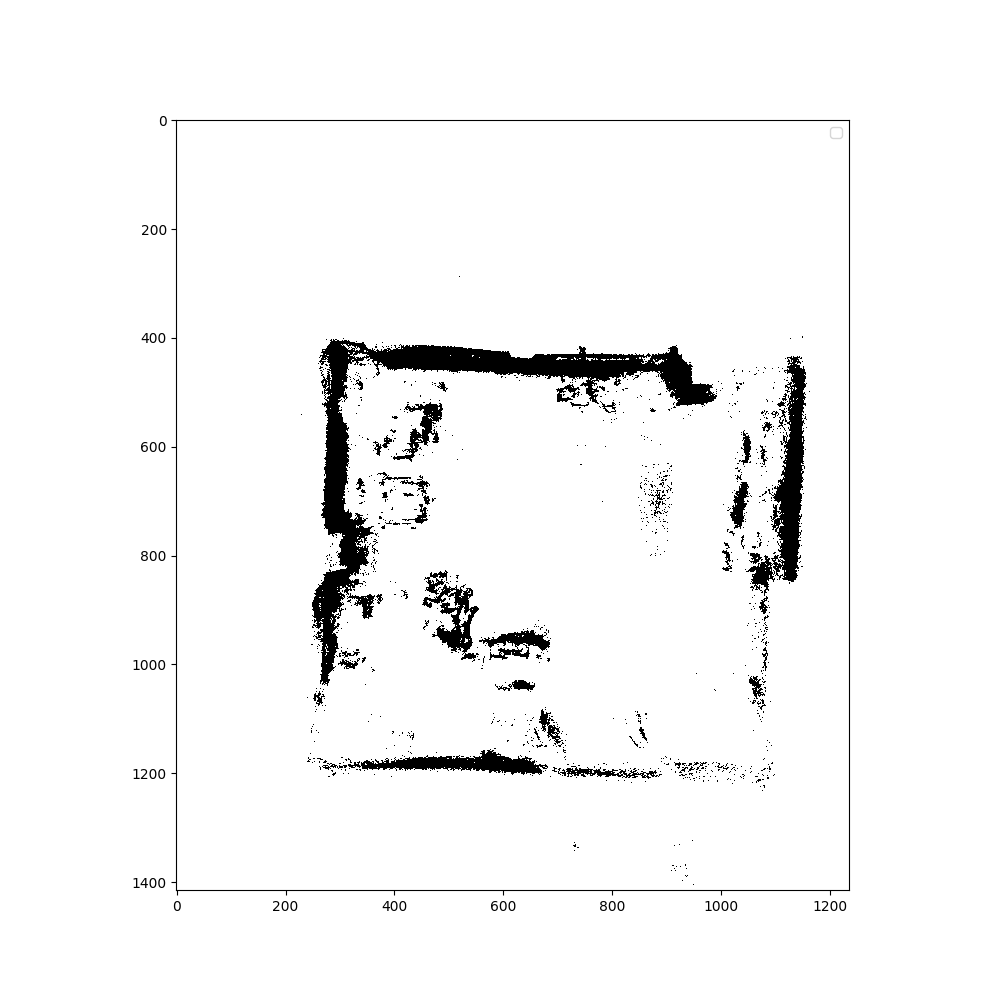

Coordinates: x=976, y=1133 || formated: [1133, 976]


In [13]:
from limp.planner.multi_level_planner import generate_obstacle_map
from limp.utils.fmt_utils import plot_map_with_points
%matplotlib widget

resolution = 0.01
h_min_bottom = -3
h_max_top = 1
obstacle_map, _, map_min_bound, map_max_bound = generate_obstacle_map(env_pointcloud, None, resolution, h_min_bottom,  h_max_top)

## Visually getting start point from map
clicked_points = plot_map_with_points(obstacle_map)

### Progressive motion planning

*************************************************
Starting Bi-level Planner
-------------------------------------------------
Obtaining predicate satisfying referent positions ...
-------------------------------------------------
Instruction predicates: ['near[green_plush_toy]', 'pick[green_plush_toy]', 'near[whiteboard::isinfrontof(green_plush_toy)]', 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'] 

Instruction predicate 1 of 4 
	Encoded Key: A || Predicate: near[green_plush_toy]                             || Predicate Action: near     || Arguments: green_plush_toy
	There are 1 element(s) with 'green_plush_toy' label
		Checking if any of these elements satisfy constraint: []
	Satisfying Elements: ['green_plush_toy_2c_1']
Instruction predicate 2 of 4 
	Encoded Key: B || Predicate: pick[green_plush_toy]                             || Predicate Action: pick     || Arguments: green_plush_toy
	There are 1 element(s) with 'green_plush_toy' label
		Checking if any of t

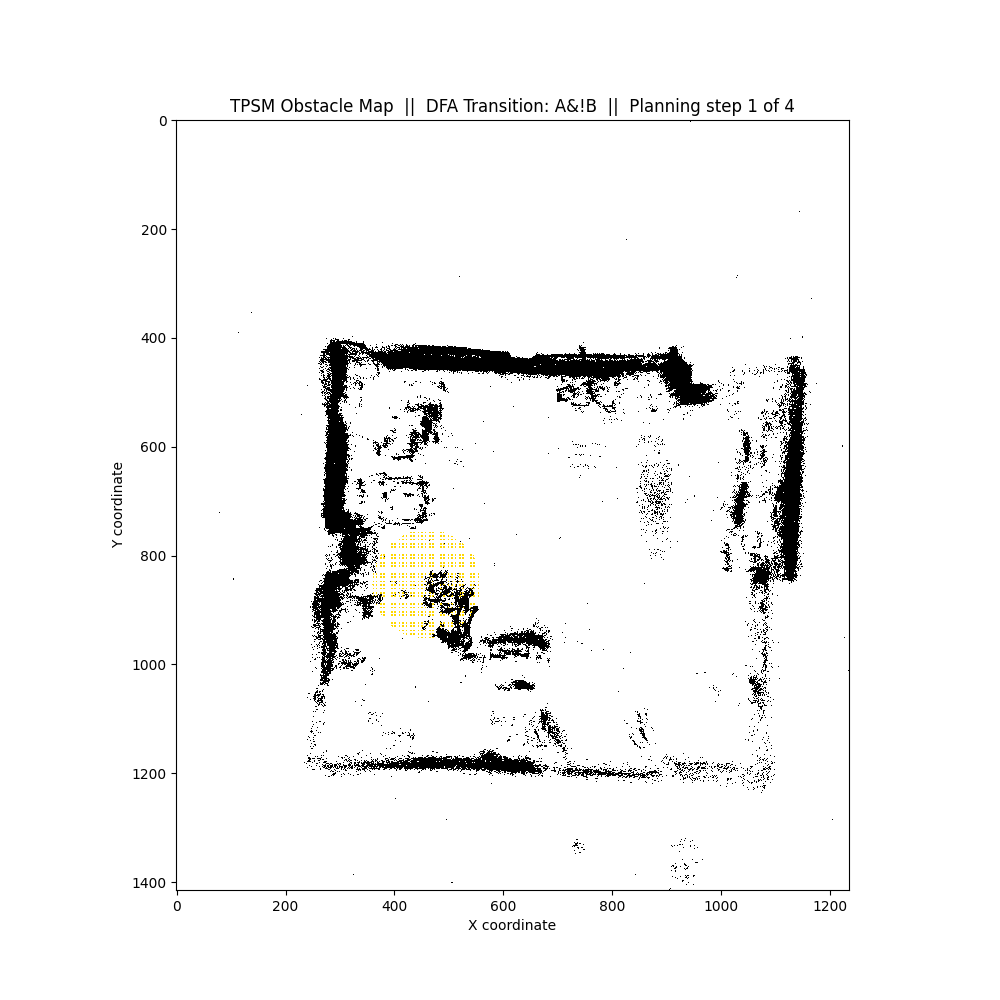

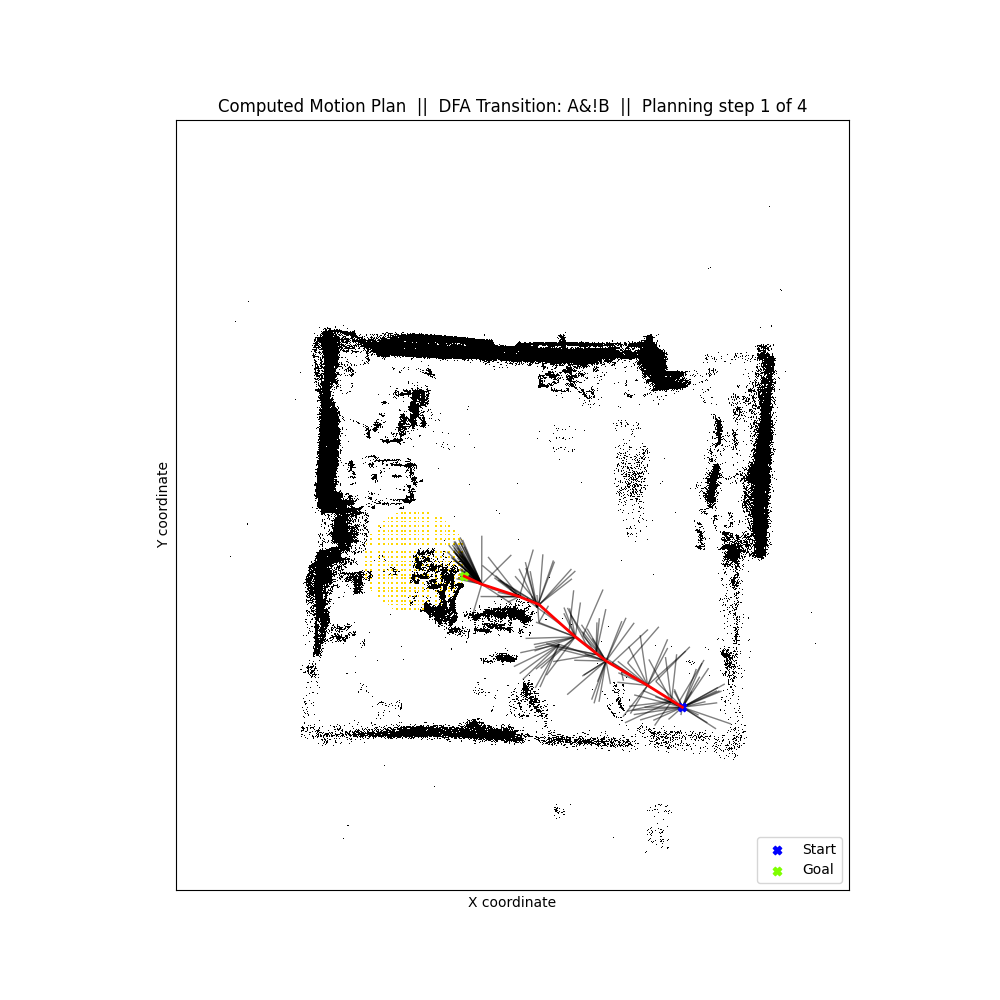

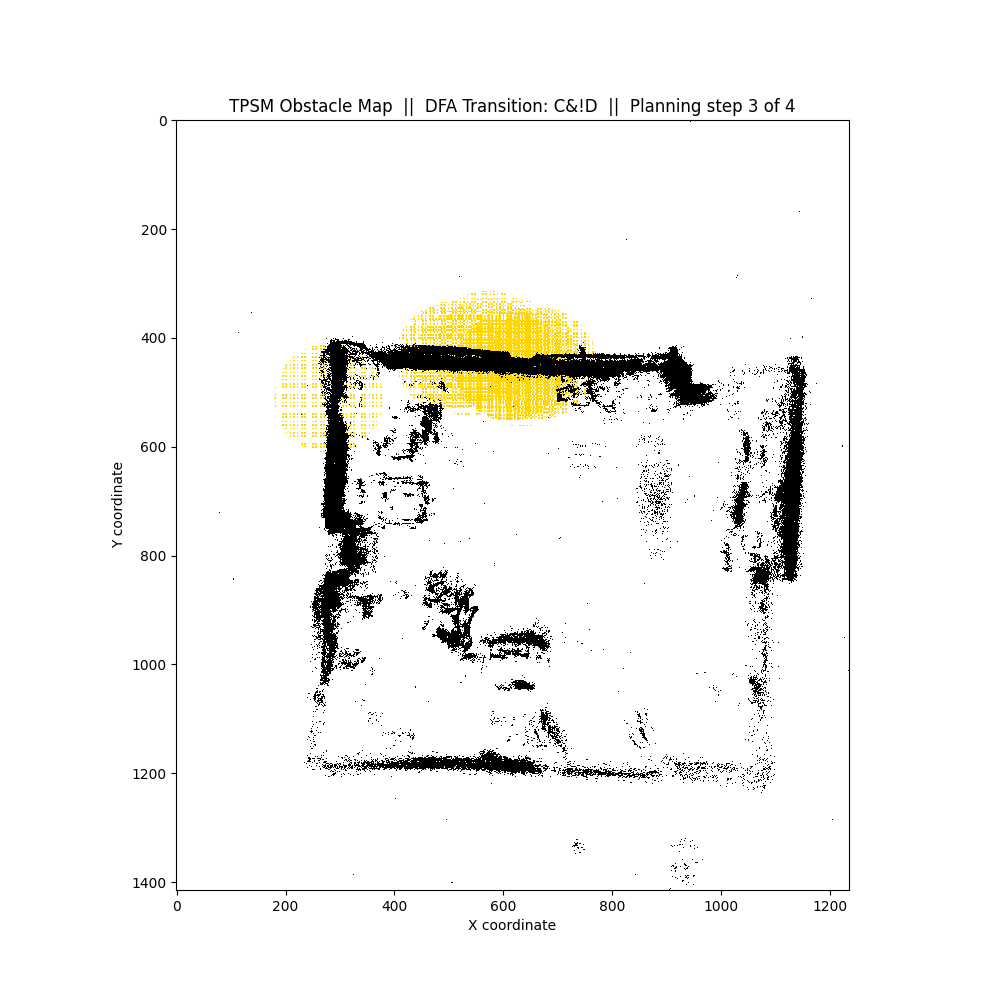

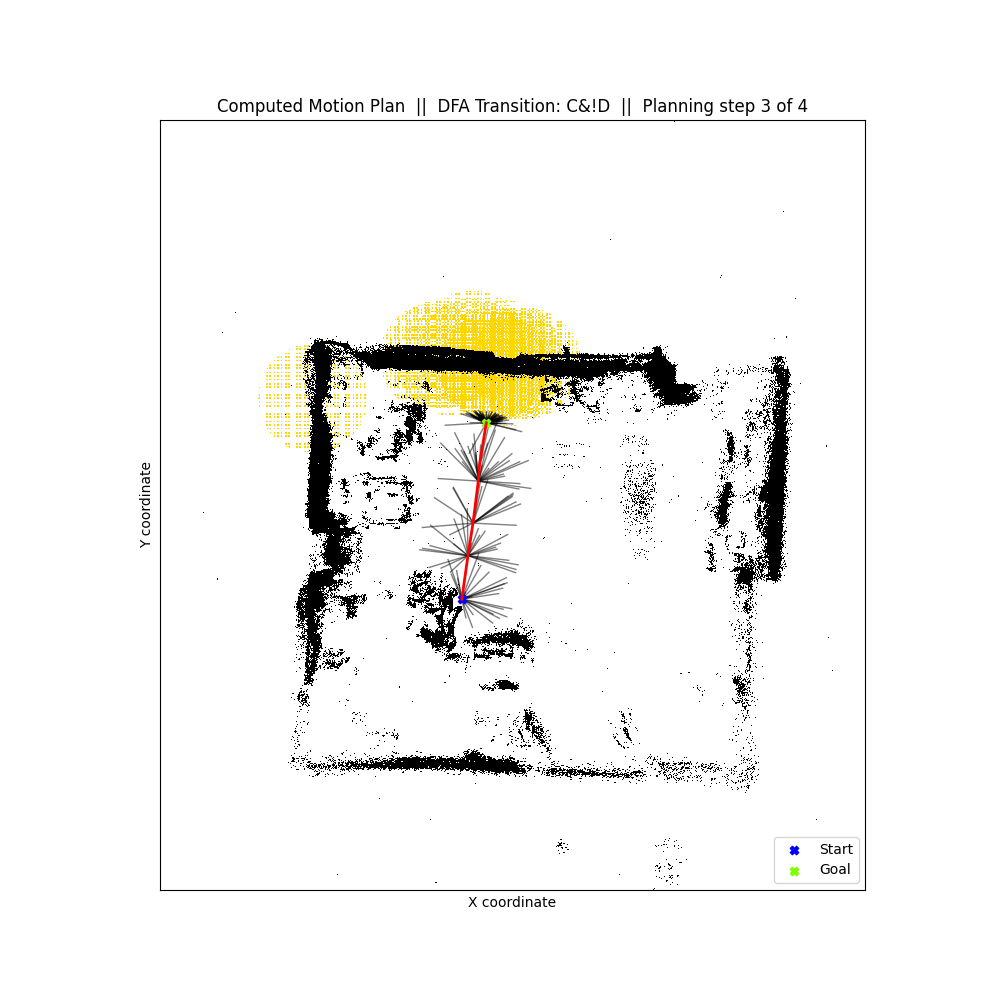

In [14]:
robot_motion_type = "2D"              #determines if planing space is 2D or 3D
z_height_2d=0                         #height of 2D planning space
      
step_factor=40                        #determines density of generated visual demarcations of regions of interest. Adjust for denser or sparser points
goal_sampling_percentage=15           #percentage of goal points to sample from the goal region to make exhaustive motion planning tractable
use_heuristic_flag=True               #determines if we use modified version of FMT* with cost to goal heuristic 
visualize_flag=True                   #determines if we visualize the computed motion plan
obstacle_map_resolution = 0.01        #determines the resolution of the obstacle map
filter_h_min_bottom = -3              #height to filter out pointcloud points below this height (meters) [Floor]      
filter_h_max_top= 1                   #height to filter out pointcloud points above this height (meters) [Roof] #see doors: 0.7 || Old value:-0.15
nearness_threshold = 1                #determines the meaning of nearness of planning space demarcation (meters)
start_point = clicked_points[-1]      #robot start location
show_color_bars_flag = False

computed_plan = progressive_motion_planner(start_point, task_dfa, dfa_graph, env_pointcloud, relevant_element_details, encoding_map, nearness_threshold, obstacle_map_resolution, filter_h_min_bottom, filter_h_max_top, robot_motion_type, height_2d=z_height_2d, stepfactor=step_factor, use_heuristic=use_heuristic_flag,visualize=visualize_flag,tmp_fldr=tmp_fldr,goal_sample_percentage=goal_sampling_percentage,show_color_bars=show_color_bars_flag)

### View Task and Motion Plan

In [15]:
computed_plan['world_plan'] 

{'step_1': {'action': 'navigation',
  'chosen_goal_referent': {'id': 'green_plush_toy_2c_1',
   'pos': array([ 3.51401164, -5.25070138, -0.1501566 ])},
  'path': array([[ 6.31201609, -0.09125637],
         [ 5.88986559, -0.76296674],
         [ 5.41904611, -1.56488784],
         [ 4.95397664, -2.15759758],
         [ 4.32925335, -2.85877305],
         [ 4.17655671, -3.23721224],
         [ 3.93779323, -3.96470572],
         [ 3.78201609, -4.30125637]])},
 'step_2': {'action': 'pick',
  'chosen_goal_referent': {'id': 'green_plush_toy_2c_1',
   'pos': array([ 3.51401164, -5.25070138, -0.1501566 ])},
  'action_parameter': 'green_plush_toy',
  'action_parameter_positions': array([{'id': 'green_plush_toy_2c_1', 'pos': array([ 3.51401164, -5.25070138, -0.1501566 ])}],
        dtype=object)},
 'step_3': {'action': 'navigation',
  'chosen_goal_referent': {'id': 'whiteboard_3c_1',
   'pos': array([-0.38075801, -3.52387641, -0.63941106])},
  'path': array([[ 3.78201609, -4.30125637],
         [ 